## DSCI100 Project - Exploring the Relationship Between Player Age and Hours Played on a Research Minecraft Server

#### I) Introduction ####
Articles from *PCGamesN* and *Search Logistics* have found that the average Minecraft player is 24 years old, and those aged 15-21 make up 43% of active players in 2025. Additionally, statistics from *Player Counter* state that in 2024, 54% of players were male, 32% were females, and 14% identified as other genders. The prevelancy in the reporting of these statistics in Minecraft player demographics indicate that many video game-related research groups find these characteristics important for data collection, recruiting, and participant targetting efforts. The aim of this project is to use K-nearest neighbors regression to predict the total number of hours a player, of given age and gender, would spend on a Minecraft server. As such, the question posed is **Can we predict how much gameplay on a Minecraft server a player will contribute given player age and gender?**


#### i) Preliminary loading of necessary libaries and setting seed

In [25]:
#loading tidyverse, tidymodels, and repr libraries
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
set.seed(9)

#### ii) Loading players.csv dataset and details
The primary dataset we will be looking at for this project is the *players.csv* dataset as it contains columns that we are interested in for algorithm prediction. *players.csv* contains columns:

- experience (chr variable type): details the experience the player has with Minecraft and/or Minecraft servers. No other information was given on how the players classified themselves on each experience type or how this was collected.
- subscribe (lgl variable type): No information was given on what this data represents or how it was collected.
- hashedEmail (chr variable type): the player's email, hashed and encrypted for privacy.
- played_hours (dbl variable type): how long, in hours, the player played on the Minecraft server. No information given on how hours were collected (whether they were the sum of total play time, etc.).
- name (chr variable type): first and/or preferred name of player.
- gender (chr variable type): gender of player.
- Age (dbl variable type): age of player at time of participation on server.


In [26]:
players<-read_csv("players.csv") #only using the players.csv data set
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


#### II) Methods and Results ####

#### i) Dataset cleaning, exploration, and visualization ####
Before doing analysis or predictions on the data, we must first thoroughly explore the players.csv dataset to determine approaches to data visualization and cleaning for proper prediction using the K-nearest neighbors regression algorithm. We should first see how the total played hours for the Minecraft server (played_hours) were distributed across players of different ages and genders. 

In [27]:
#Cleaning dataset to only include played_hours, age, and gender -- our variables of interest
playerdemog<-players|>
    select(played_hours, Age, gender)|>
    na.omit()|> #Ensures that no NA values are present in data
    arrange(-played_hours) #Arranges data by descending played_hours
playerdemog

#Exploring the maximal and minimal hours 
head(playerdemog)
tail(playerdemog)
count(playerdemog, played_hours==0)


played_hours,Age,gender
<dbl>,<dbl>,<chr>
223.1,17,Male
218.1,20,Non-binary
178.2,19,Female
150.0,16,Female
56.1,23,Male
⋮,⋮,⋮
0,17,Female
0,17,Male
0,20,Male


played_hours,Age,gender
<dbl>,<dbl>,<chr>
223.1,17,Male
218.1,20,Non-binary
178.2,19,Female
150.0,16,Female
56.1,23,Male
53.9,17,Male


played_hours,Age,gender
<dbl>,<dbl>,<chr>
0,17,Male
0,17,Female
0,17,Male
0,20,Male
0,17,Female
0,17,Prefer not to say


played_hours == 0,n
<lgl>,<int>
FALSE,109
TRUE,85


We notice that the range in played_hours is very large and extremely skewed. Out of the 194 players in our dataset, 4 played 100+ hours on the server, while 85 played 0 hours. Let us create a scatterplot to visualize player age (Age) vs total hours (played_hours), and create subplots which are ordered by gender to see how played_hours is distributed between age and gender. Due to the extremely wide range of data values in terms of played_hours, it is better to plot Age vs *log* of played_hours to ensure easier comprehensibility in the plot.

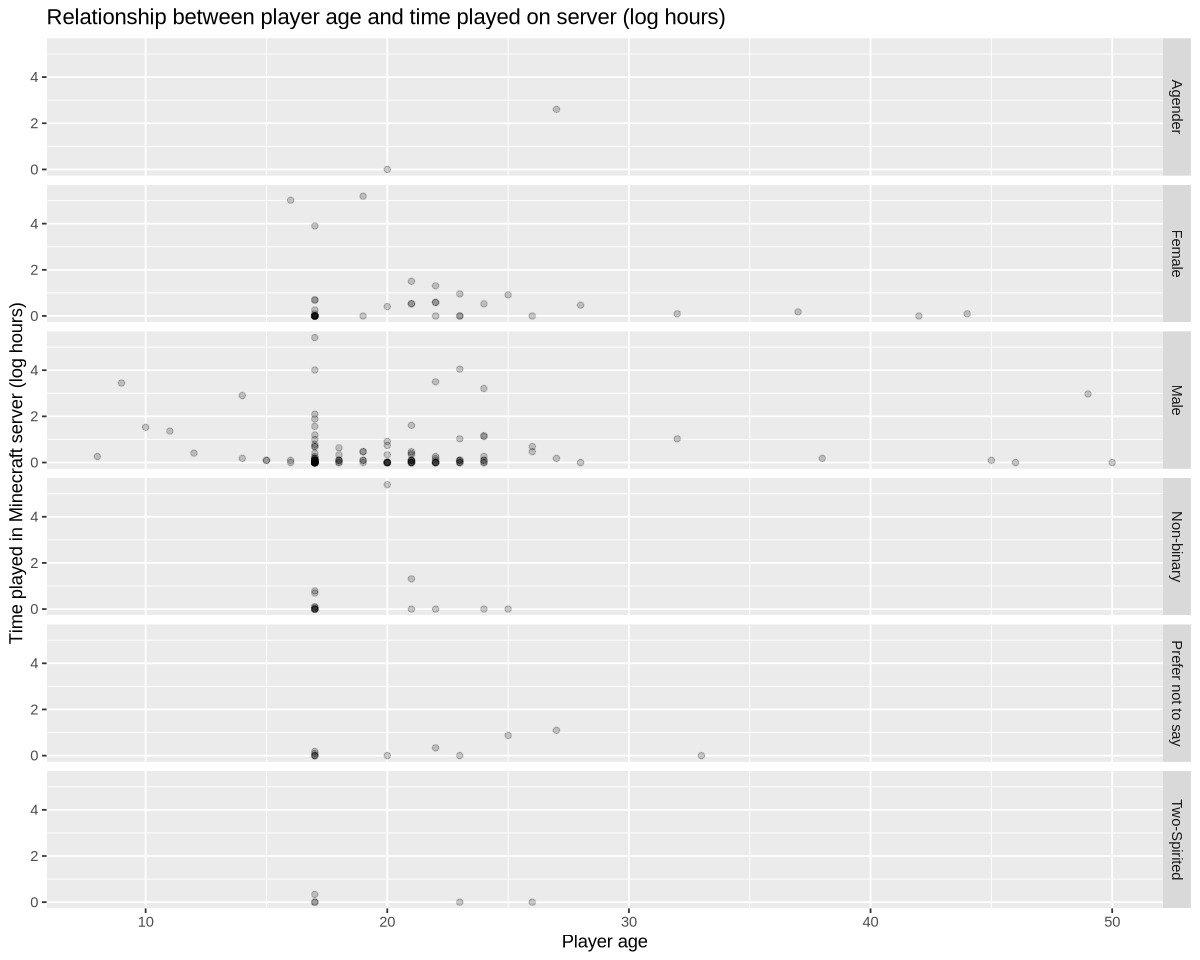

In [28]:
#Converting played_hours to log_played_hours for better data plotting visualization
explore_playerdemog<-playerdemog|>
    mutate(log_hours=log(1+played_hours))

#Scatterplot of log_played_hours and age
options(repr.plot.width=10, repr.plot.length=7) #Adjusting size of plot

explore_table<-explore_playerdemog|>
    ggplot(aes(x=Age, y=log_hours))+
    geom_point(alpha=0.2)+
    facet_grid(vars(rows=gender))+
    labs(x="Player age", y="Time played in Minecraft server (log hours)")+
    ggtitle("Relationship between player age and time played on server (log hours)")
explore_table

**Figure 1:** *The majority of players on the Minecraft server identified as male, and significant numbers of players played less than 1 hour and/or 0 hours.* Stacked scatterplot grid of player age vs log total hours played on Minecraft server, organized by gender. Datapoints have been made transparent to further visualize skewed data distribution. played_hours, gender, and Age from the players.csv dataset were plotted. 

We see the data is skewed as there are signficantly more male-identifying players in our data set, and a vast majority played less than 1 hour and/or 0 hours. There does not seem to be any relationship with age and gender regarding hours played on the server. While we can see that the dataset agrees with the statistic that a significant portion of the Minecraft players are males and aged 15-21, we should continue with creating a K-NN regression algorithm to predict played_hours for ages and genders.

#### ii) K-Nearest Neighbors Algorithm Formation ####

In [29]:
#Mutating the playerdemog dataset to assign genders to numerical values
#This will allow for easier scaling in the algorithm
playerdemog$gender<-as.integer(factor(playerdemog$gender))
playerdemog


played_hours,Age,gender
<dbl>,<dbl>,<int>
223.1,17,3
218.1,20,4
178.2,19,2
150.0,16,2
56.1,23,3
⋮,⋮,⋮
0,17,2
0,17,3
0,20,3


**Gender-numeric assignment:** 

1) Agender
2) Female
3) Male
4) Non-Binary
5) Two-Sprited
6) Prefer not to say

We will be doing a K-NN regression algorithm as the data is not significantly linear (especially in ages 15-25) and K-NN does not need a specific shape to perform well. Additionally, we will be splitting the data 70:30 training:testing as more training points will hopefully make a better-trained algorithm that can predict points outside of the training set better, especially due to the extreme variation in point distribution. We will be tuning the algorithm and conducting 5-fold cross validation to hopefully estimate the best k with minimal root mean square error RMSE, and evaluate performance in properly predicting played_hours given Age and gender using the validation set. Since we've converted the genders to numerical values, we would need to scale all_predictors() to ensure our data is standardized and both gender and age would have the same weight in the predictor.

There is a high potential for our algorithm to be bad at predicting due to the significant skew in the data (abundance of datapoints for males aged 15-25, but very few comparatively for other ages and genders). However, doing 5-fold cross validation to determine the best k (given the folding pattern) and testing RMSPE to find the most minimal deviation in data will hopefully result in a more accurate prediction algorithm.

In [30]:
#Split data into training and testing data sets, 70:30 in training:testing 
isplit<-initial_split(playerdemog, prop=0.7, strata=played_hours)
player_training<-training(isplit)
player_testing<-testing(isplit)

#Forming a recipe 
hour_recipe<-recipe(played_hours ~., data=player_training)|>  #using all predictors in the dataset
    step_scale(all_predictors())|> 
    step_center(all_predictors()) 

#Forming a tuning model to determine best k
tune_spec<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("regression") #doing a regression algorithm to predict played hours

#5-fold cross-validation 
vfold<-vfold_cv(player_training, v=5, strata=played_hours)

#Developing a tuning fit
tune_fit<-workflow()|>
    add_recipe(hour_recipe)|>
    add_model(tune_spec)

#Setting a range of k=1-10 to find the best k
kvals<-tibble(neighbors=seq(from=1, to=10, by=1))

#Collecting data to find the smallest RMSE
kvals_result<-tune_fit|>
    tune_grid(resamples=vfold, grid=kvals)|>
    collect_metrics()|>
    filter(.metric=="rmse")
kvals_result

#Finding k value with minimal RMSE 
kvals_min<-kvals_result|>
   slice_min(mean, n=1)|>
    pull(neighbors)
kvals_min


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,31.81063,5,10.131891,Preprocessor1_Model01
2,rmse,standard,30.79858,5,9.629263,Preprocessor1_Model02
3,rmse,standard,33.27769,5,8.056383,Preprocessor1_Model03
4,rmse,standard,34.12947,5,7.353616,Preprocessor1_Model04
5,rmse,standard,33.37994,5,7.760643,Preprocessor1_Model05
6,rmse,standard,32.41899,5,8.061349,Preprocessor1_Model06
7,rmse,standard,32.34742,5,7.978262,Preprocessor1_Model07
8,rmse,standard,31.74127,5,8.067537,Preprocessor1_Model08
9,rmse,standard,31.95110,5,7.913146,Preprocessor1_Model09


[1] 2

k=2 is a fairly low k value. However, it makes sense it results in the smallest RMSPE as in ranges outside of males aged 15-21, datapoints are lackluster and have wide distributions between them. As such, a small k=2 would essentially ignore values with larger played hours, and the predictions would be closer to more common observations (those who played <1 hour).

In [31]:
#Assess RMSPE on testing data
#Using same recipe, hour_recipe

#Make new model using best k
kmin_spec<-nearest_neighbor(weight_func="rectangular", neighbors=kvals_min)|>
    set_engine("kknn")|>
    set_mode("regression")

#Fitting best k spec on testing data
kmin_fit<-workflow()|>
    add_recipe(hour_recipe)|>
    add_model(kmin_spec)|>
    fit(data=player_testing)

In [32]:
#Finding RMSPE for testing data -- testing algorithm on predicting unseen data
test_predictions<-kmin_fit|>
    predict(player_testing)|>
    bind_cols(player_testing)

hour_summary<-test_predictions|>
    metrics(truth=played_hours, estimate=.pred)|>
    filter(.metric=="rmse")
hour_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.96035


Since RMSE is estimated to be 3.96035, we can see that there is an approximately 4 hour error between the predictions and the testing set.

#### iii) Plotting predictions ####
Now that we've created a KNN algorithm, we should create a scatterplot to visualize played_hours predictions (and their associated RMSE) to the actual training data to see relationship between played_hours, gender, and age. 

In [33]:
#Creating dataset with predictions and the actual played_hours
hour_preds<-kmin_fit|>
    predict(player_training)|> #create predictions for training data
    bind_cols(player_training) #binding predictions to the actual data in the TRAINING DATA SET
hour_preds

.pred,played_hours,Age,gender
<dbl>,<dbl>,<dbl>,<int>
0.25,0.1,21,3
0.50,0.1,17,2
0.25,0.1,21,3
1.10,0.1,17,4
0.25,0.1,21,3
⋮,⋮,⋮,⋮
0.50,1.0,17,2
11.95,1.0,26,3
0.25,0.9,18,3


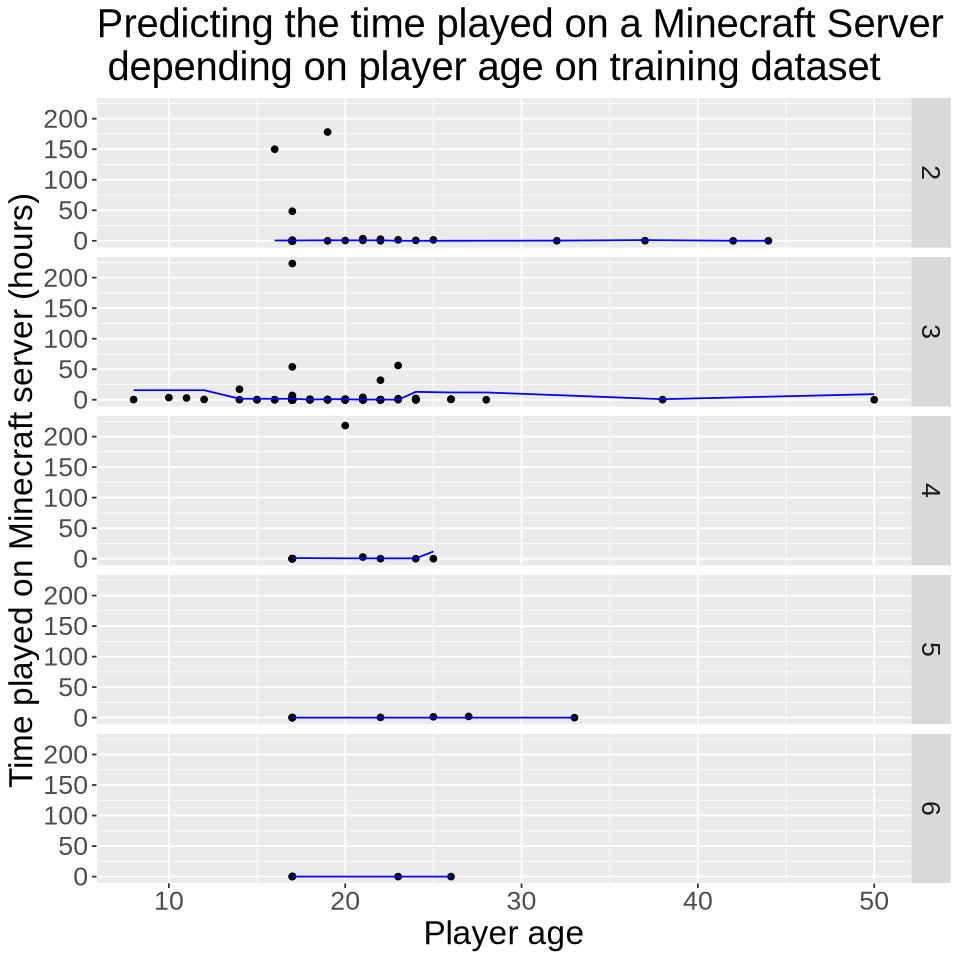

In [34]:
#Plotting prediction algorithm on training data
options(repr.plot.width=8, repr.plot.height=8)

player_preds<-hour_preds|>
    ggplot()+
    geom_point(aes(x=Age, y=played_hours)) + #plotting training data as a scatter plot
    geom_line(data=hour_preds, #plotting predictions as a blue line on the scatterplot
              mapping=aes(x=Age, y=.pred),
            color="blue", 
             )+
    facet_grid(vars(rows=gender))+
    labs(x="Player age", y="Time played on Minecraft server (hours)", 
         title="Predicting the time played on a Minecraft Server\n depending on player age on training dataset"
        )+
    theme(text=element_text(size=20))

player_preds

**Figure 2:** *Algorithm predictions of time played on Minecraft servers for different genders and age plotted against training dataset observations of player age vs time played for different gender.* Blue line represents the predictions that the algorithm made for time played (hours) for each gender and age. Agender predictions is missing from training dataset. 


Note that an agender plot is missing. Agender only had two datapoints, and due to random distribution in the training set, distributed such that the data is not present in the training set. This means that any predictions to be done on agender observations in this particular seed/training:testing split will not occcur, as the data was not trained on agender observations. Let us plot the testing datapoints and predictions made to confirm whether location of agender observations and whether predictions were made.

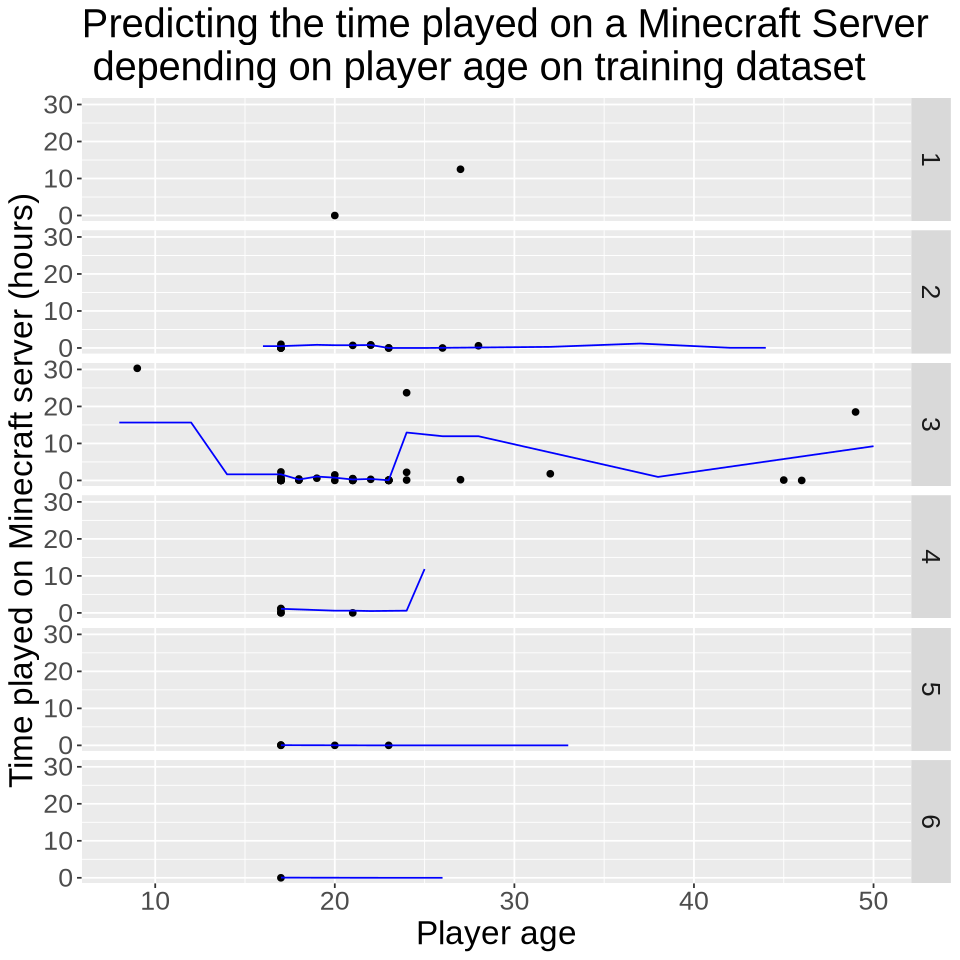

In [35]:
#Plotting prediction algorithm on training data
options(repr.plot.width=8, repr.plot.height=8)

test_preds<-test_predictions|>
    ggplot()+
    geom_point(aes(x=Age, y=played_hours)) + #plotting testing data as a scatter plot
    geom_line(data=hour_preds, #plotting predictions on testing dataset as a blue line on the scatterplot
              mapping=aes(x=Age, y=.pred),
            color="blue", 
             )+
    facet_grid(vars(rows=gender))+
    labs(x="Player age", y="Time played on Minecraft server (hours)",
         title="Predicting the time played on a Minecraft Server\n depending on player age on training dataset"
        )+
    theme(text=element_text(size=20))

test_preds

**Figure 3:** *Algorithm predictions of time played on Minecraft servers for different genders and age plotted against testing dataset observations of player age vs time played for different gender.* Blue line represents the predictions that the algorithm made for time played (hours) for each gender and age. Visualizes split of data that went into testing dataset. Both agender observations were randomly split into testing dataset so algorithm was not trained on predicting time played for agender individuals. 

We see that the agender observations are present in the testing dataset, but no prediction for them occured. 


#### III) Discussion ####

The KNN regression algorithm predicted time played on a Minecraft server (hours) for different ages of individuals with different gender identities. Visually plotting the prediction results in fairly flat horizontal lines, and a calculted RMSE of 3.96035 for a 5-fold cross validaton-found k of k=2 was found. In this specific random data split, this is what one would expect. While this algorithm **can predict how much gameplay on a Minecraft server a player will contribute given player age and gender**, the predictions contain significant error (up to 4 hours error in predictions). However, the algorithm will be able to predict time played to a significant degree for those of different ages of different genders. These findings could be impactful on research groups attempting to recruit those who would contribute significant data to a research Minecraft server, which would be significant in data collection for future experiments. Future questions can involve more variables into the data to potentially search for trends. For example, can we predict how much gameplay on a Minecraft server a player will contribute based on age, gender, day of the week, profficiency, etc.? These questions could be significant in further predicting and exploring how different demographics may contribute significant data.

#### IV) References ####

Capel, Chris J. “Believe It or Not, the Average Age of a Minecraft Player Is 24.” PCGamesN, PCGamesN, 25 Sept. 2019, www.pcgamesn.com/minecraft/player-age.

Woodward, Matthew. “Minecraft User Statistics: How Many People Play Minecraft in 2023?” Www.searchlogistics.com, 24 Aug. 2022, www.searchlogistics.com/learn/statistics/minecraft-user-statistics/.

‌“Minecraft Live Player Count - How Many People Are Playing Now?” Playercounter.com, 5 Mar. 2019, playercounter.com/minecraft/.‌